### Imports

In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import numpy as np
import inspect
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


### Reading Data

In [60]:
data = pickle.load(open("data_preprocessing/preprocessed_hr_data.pkl", "rb"))

In [9]:
data = pd.read_csv("../data/HR.csv")
data = data.rename(columns={"sales": "department"})
data = pd.get_dummies(data)
categorical = ['department_IT', 'department_RandD', 'department_accounting', 'department_hr', 'department_management', 'department_marketing', 'department_product_mng', 'department_sales', 'department_support', 'department_technical', 'salary_high', 'salary_low', 'salary_medium']
data[categorical] = data[categorical].astype(float)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Exploring Data

In [10]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Splitting Data Into Train and Test Set

In [12]:
y = data['left']
X = data.drop(columns=['left'])

In [13]:
#X_train, X_test, y_train, y_test = data['supervised']['X_train'], data['supervised']['X_test'], data['supervised']['y_train'], data['supervised']['y_test']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 11999
Test set size: 3000


### Converting Data into Tensors

In [14]:


feature_names = X_train.columns.tolist()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

### Training the XGBoost Model

In [65]:
train_dmatrix = xgb.DMatrix(X_train_tensor, label=y_train_tensor, feature_names=feature_names)
test_dmatrix = xgb.DMatrix(X_test_tensor, label=y_test_tensor, feature_names=feature_names)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 100

xgb_model = xgb.train(params, train_dmatrix, num_rounds)


### Geting Predictions

In [66]:
preds = xgb_model.predict(test_dmatrix)

print(preds)


[0.0064815  0.00048382 0.00973245 ... 0.01106615 0.00891291 0.01205195]


### Finding the Treshold That Maximizes The f1 Score

In [67]:
threshold = 0
f1_scores = []
while threshold < 1:
    threshold += 0.01
    binary_preds = [1 if p >= threshold else 0 for p in preds]
    f1 = f1_score(y_test, binary_preds)
    f1_scores.append((threshold,f1))

best_treshold = max(f1_scores, key=lambda x: x[1])[0]
best_treshold

0.37000000000000016

### Different Metrics to Measure Model Performance

In [68]:
binary_preds = [1 if p >= best_treshold else 0 for p in preds]

accuracy = accuracy_score(y_test, binary_preds)
precision = precision_score(y_test, binary_preds)
recall = recall_score(y_test, binary_preds)
f1 = f1_score(y_test, binary_preds)
conf_matrix = confusion_matrix(y_test, binary_preds)
logloss = log_loss(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Log Loss: {logloss:.4f}")

print()

print("Precision of stayed (0): ", conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1]))
print("Precision of left (1): ", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))

print("Recall of stayed (0): ", conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[1][0]))
print("Recall of left (1): ", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1]))

recal_left = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
precision_left = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])

print("F1 Score of stayed (0): ", 2*conf_matrix[0][0]/(2*conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]))
print("F1 Score of left (1): ", 2*recal_left*precision_left/(recal_left+precision_left))

Accuracy: 0.9807
Precision: 0.9699
Recall: 0.9482
F1 Score: 0.9589
Confusion Matrix: 
[[2265   21]
 [  37  677]]
Log Loss: 0.0660

Precision of stayed (0):  0.9908136482939632
Precision of left (1):  0.9481792717086834
Recall of stayed (0):  0.9839270199826238
Recall of left (1):  0.9699140401146131
F1 Score of stayed (0):  0.9873583260680034
F1 Score of left (1):  0.9589235127478754


### Precision and Recall Curve

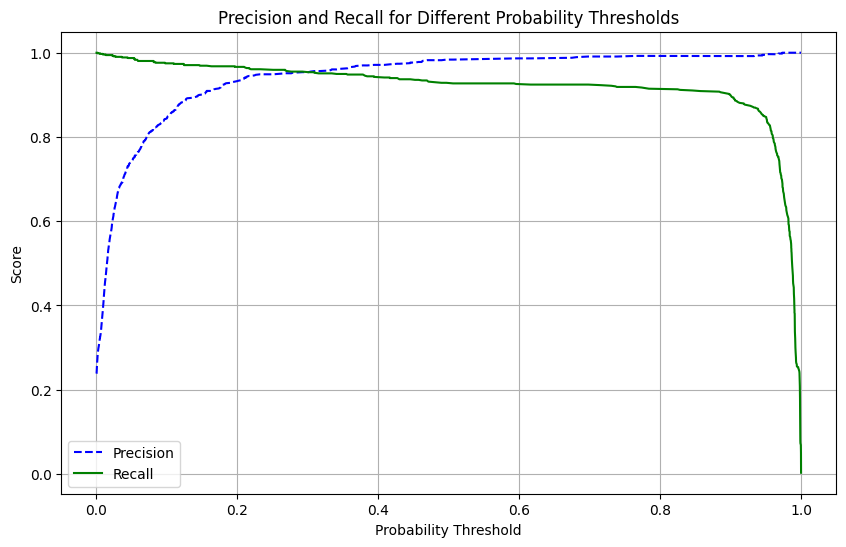

In [69]:
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, preds)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_curve[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall_curve[:-1], 'g-', label='Recall')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall for Different Probability Thresholds')
plt.legend()
plt.grid(True)
plt.show()

### Probability Distribution by Class

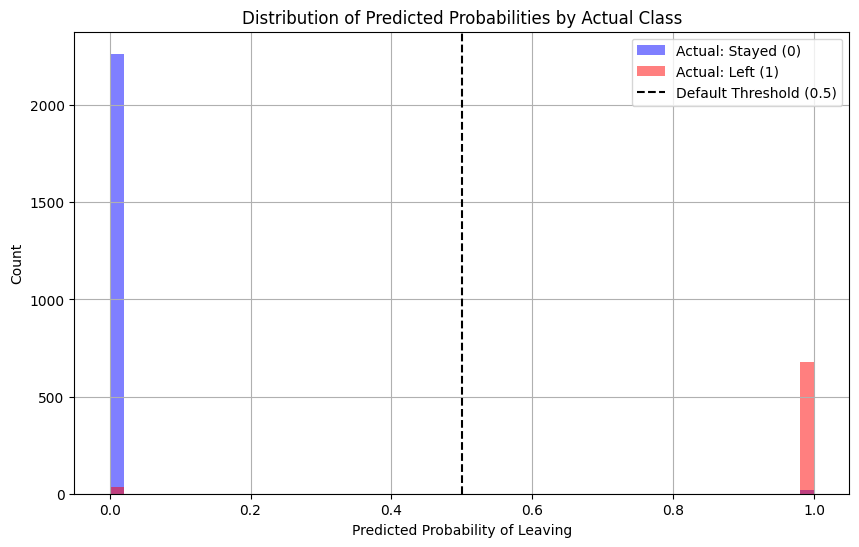

In [70]:
plt.figure(figsize=(10, 6))

prob_class_0 = [binary_preds[i] for i in range(len(y_test)) if y_test.iloc[i].item() == 0]
prob_class_1 = [binary_preds[i] for i in range(len(y_test)) if y_test.iloc[i].item() == 1]

plt.hist(prob_class_0, bins=50, alpha=0.5, label='Actual: Stayed (0)', color='blue')
plt.hist(prob_class_1, bins=50, alpha=0.5, label='Actual: Left (1)', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Predicted Probability of Leaving')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.legend()
plt.grid(True)
plt.show()

### Class Distribution Analysis

Class distribution in training data:
left
0.0     9142
1.0     2857
Name: count, dtype: int64
Percentage of employees who left: 23.81%


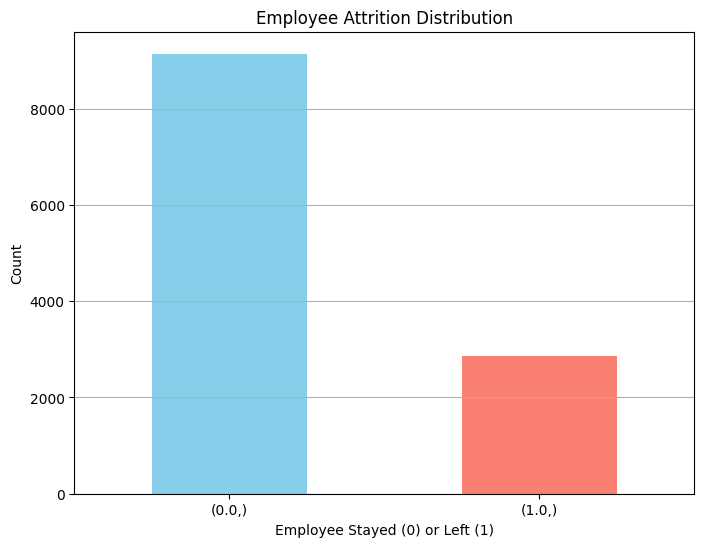

In [71]:
class_distribution = y_train.value_counts()
print("Class distribution in training data:")
print(class_distribution)
print(f"Percentage of employees who left: {class_distribution[1]/len(y_train)*100:.2f}%")

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Employee Attrition Distribution')
plt.xlabel('Employee Stayed (0) or Left (1)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()



### Feature Importance Analysis

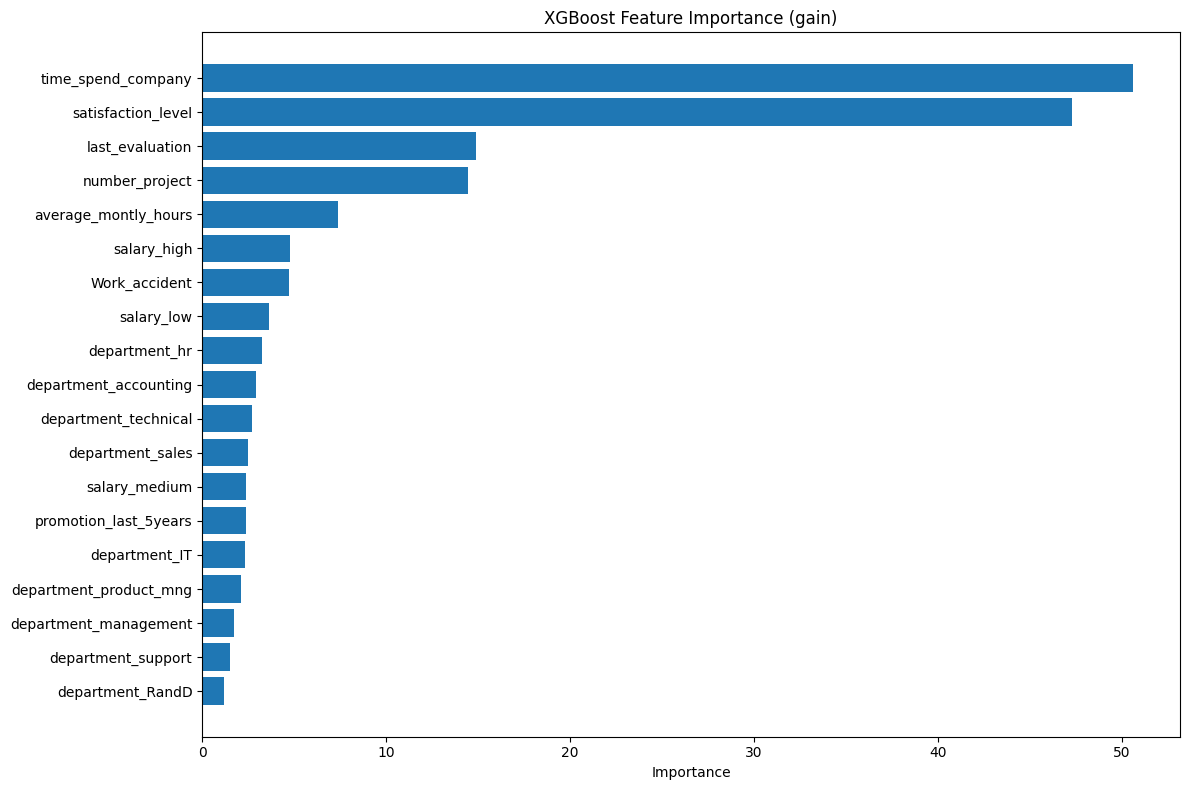


Feature Importance (weight):
                 Feature  Importance (weight)
0     satisfaction_level                645.0
3   average_montly_hours                532.0
1        last_evaluation                437.0
4     time_spend_company                321.0
2         number_project                304.0
17            salary_low                 57.0
15  department_technical                 43.0
5          Work_accident                 42.0
13      department_sales                 35.0
16           salary_high                 34.0

Feature Importance (cover):
                   Feature  Importance (cover)
12  department_product_mng          230.295410
4       time_spend_company          230.173477
5            Work_accident          201.766510
16             salary_high          187.142914
6    promotion_last_5years          184.649490
2           number_project          173.551605
11   department_management          168.345367
0       satisfaction_level          163.429596
8         de

In [72]:

importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance (gain)')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

for imp_type in ['weight', 'cover', 'total_gain', 'total_cover']:
    try:
        importance = xgb_model.get_score(importance_type=imp_type)
        importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', f'Importance ({imp_type})'])
        importance_df = importance_df.sort_values(f'Importance ({imp_type})', ascending=False)
        print(f"\nFeature Importance ({imp_type}):")
        print(importance_df.head(10))  
    except:
        print(f"Importance type '{imp_type}' not available")

### Save The Trained Model

In [73]:
model_path = "xgboost_hr_attrition_model.json"
xgb_model.save_model(model_path)

c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Summary of How Features Affect Attrition:
                   Feature       Effect Direction  Importance  Correlation
0       satisfaction_level  ↓ Decreases attrition    2.112728    -0.699812
4       time_spend_company  ↑ Increases attrition    0.874661     0.471810
2           number_project  ↓ Decreases attrition    0.650077    -0.233845
3     average_montly_hours  ↑ Increases attrition    0.421972     0.492318
1          last_evaluation  ↑ Increases attrition    0.386377     0.412777
5            Work_accident  ↓ Decreases attrition    0.217388    -0.946555
18              salary_low  ↑ Increases attrition    0.155548     0.900675
17             salary_high  ↓ Decreases attrition    0.115256    -0.952902
13  department_product_mng  ↓ Decreases attrition    0.050349    -0.931982
14        department_sales  ↑ Increases attrition    0.041591     0.781209
16    department_technical  ↑ Increases attrition    0.038972     0.743171
10           department_hr  ↑ Increases attrition    0.02

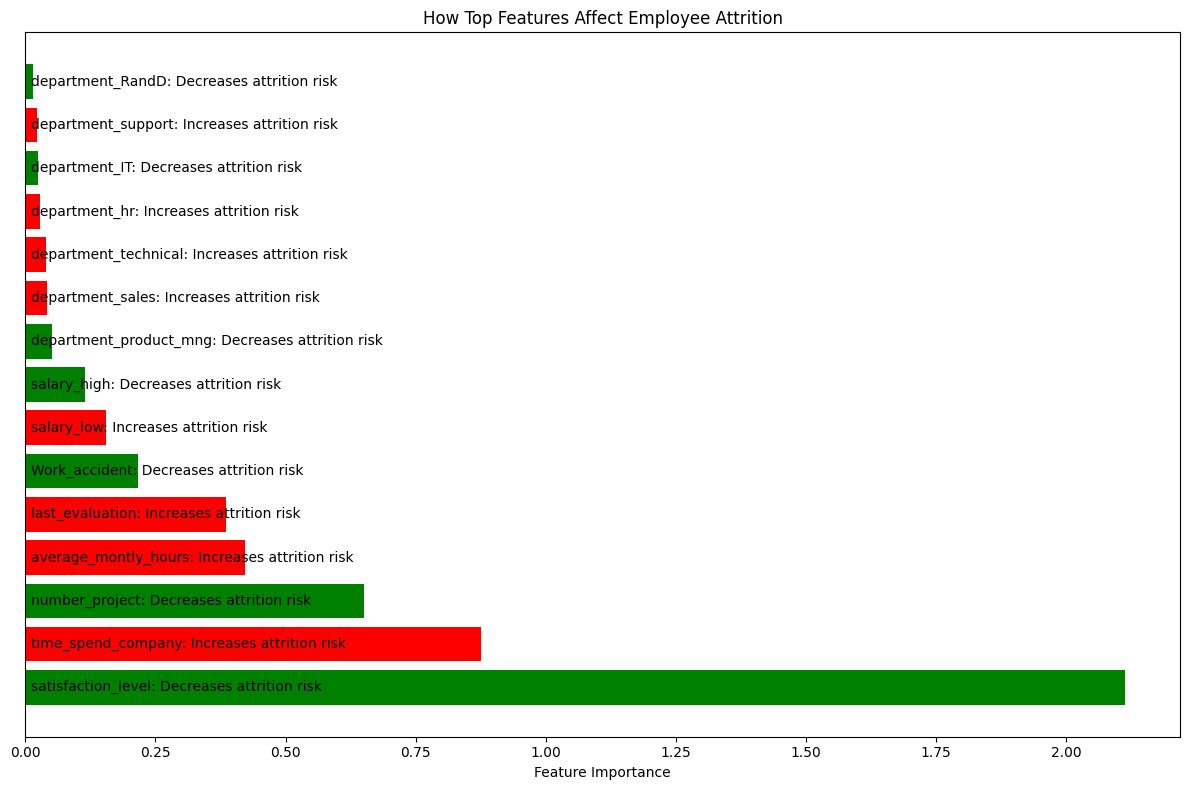

In [74]:
### Summary Table of Feature Effects
import shap

# Create explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for test set (or a sample if it's large)
sample_size = min(500, X_test_tensor.shape[0])  # Limit sample size for speed
X_sample = X_test_tensor[:sample_size].numpy()
X_sample_dmatrix = xgb.DMatrix(X_sample, feature_names=feature_names)
shap_values = explainer.shap_values(X_sample_dmatrix)

# Calculate average effect direction for each feature
feature_effects = []

for i, feature in enumerate(feature_names):
    # Calculate correlation between feature and SHAP value
    if i < shap_values.shape[1]:  # Make sure feature index is valid
        feature_values = X_sample[:, i]
        shap_impact = shap_values[:, i]
        correlation = np.corrcoef(feature_values, shap_impact)[0, 1]
        
        # Determine effect direction
        if abs(correlation) < 0.1:
            effect = "Minimal/Non-linear"
        elif correlation > 0:
            effect = "↑ Increases attrition"
        else:
            effect = "↓ Decreases attrition"
        
        # Calculate average absolute SHAP value (importance)
        importance = np.mean(np.abs(shap_impact))
        
        feature_effects.append({
            'Feature': feature,
            'Effect Direction': effect,
            'Importance': importance,
            'Correlation': correlation
        })

# Create DataFrame and sort by importance
effect_df = pd.DataFrame(feature_effects)
effect_df = effect_df.sort_values('Importance', ascending=False)

# Display the table
print("\nSummary of How Features Affect Attrition:")
print(effect_df.head(15))  # Show top 15 features

# Create a more visual summary for key features
plt.figure(figsize=(12, 8))
top_features = effect_df.head(15)['Feature'].tolist()

for i, feature in enumerate(top_features):
    idx = feature_names.index(feature)
    corr = effect_df[effect_df['Feature'] == feature]['Correlation'].values[0]
    
    # Determine color based on correlation
    if abs(corr) < 0.1:
        color = 'gray'
        effect = "Minimal/Non-linear effect"
    elif corr > 0:
        color = 'red'
        effect = "Increases attrition risk"
    else:
        color = 'green'
        effect = "Decreases attrition risk"
    
    plt.barh(i, effect_df[effect_df['Feature'] == feature]['Importance'].values[0], color=color)
    plt.text(0.01, i, f"{feature}: {effect}", va='center')

plt.yticks([])  # Hide y-axis labels since we added text
plt.xlabel('Feature Importance')
plt.title('How Top Features Affect Employee Attrition')
plt.tight_layout()
plt.show()

In [90]:


def predict_attrition(employee_data):
    """
    Make attrition predictions for new employee data.
    
    Args:
        employee_data: A dictionary or pandas DataFrame with employee features
                      (must have the same features as your training data)
        
    Returns:
        Dictionary with prediction probability and binary prediction
    """
    if isinstance(employee_data, dict):
       employee_data = pd.DataFrame([employee_data])
    

    employee_data_encoded = pd.get_dummies(employee_data)


    for col in feature_names:
        if col not in employee_data_encoded.columns:
            employee_data_encoded[col] = 0

    employee_data_encoded = employee_data_encoded[feature_names]


    dmatrix = xgb.DMatrix(employee_data_encoded, feature_names=feature_names)

    probability = xgb_model.predict(dmatrix)[0]
    prediction = 1 if probability > 0.37 else 0
    
    return {
        "probability": float(probability),
        "prediction": int(prediction),
        "will_leave": bool(prediction == 1)
    }

with open("prediction_pipeline.py", "w") as f:
    f.write(inspect.getsource(predict_attrition))
print("Prediction pipeline saved")

sample_employee = {
    "satisfaction_level": 0,
    "last_evaluation": 0,
    "number_project": 5,
    "average_montly_hours": 4,
    "time_spend_company": 3,
    "Work_accident": 0,
    "promotion_last_5years": 0,
    "department": "sales",
    "salary": "low"
}

prediction_result = predict_attrition(sample_employee)
print("\nSample prediction:")
print(f"Probability of leaving: {prediction_result['probability']:.4f}")
print(f"Will leave: {prediction_result['will_leave']}")


Prediction pipeline saved

Sample prediction:
Probability of leaving: 0.0729
Will leave: False
